In [1]:
import os
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.preprocessing import OneHotEncoder
import lightning.pytorch as L
from model import CVAE
from datetime import datetime
from os.path import join
import pytz
from anndata import AnnData
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.decomposition import PCA
from collections import defaultdict
import scvi
from sklearn.model_selection import KFold
from utils import evaluate
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cell_type_col = "classes"

In [4]:
adata = sc.read_h5ad("post_qc.h5ad")
adata

AnnData object with n_obs × n_vars = 65930 × 15093
    obs: 'classes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'classes_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)
train_index, valid_index = next(kf.split(range(len(adata))))  
valid_index

array([   10,    12,    25, ..., 65883, 65890, 65904])

In [6]:
adata_train = adata[adata.obs_names[train_index]].copy()
adata_valid = adata[adata.obs_names[valid_index]].copy()

In [7]:
scvi.model.SCVI.setup_anndata(adata_train, batch_key=None, labels_key=cell_type_col)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:
scvi_model = scvi.model.SCVI(adata_train, n_latent=30, n_layers=2)

In [9]:
scvi_model.train(100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/miniconda3/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|█| 100/100 [06:06<00:00,  4.20s/it, v_num=1, train_loss_st

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|█| 100/100 [06:06<00:00,  3.67s/it, v_num=1, train_loss_st


In [10]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, "Unknown")

In [11]:
scanvi_model.train(25)

INFO     Training for 25 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/miniconda3/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 25/25: 100%|█| 25/25 [04:00<00:00,  9.47s/it, v_num=1, train_loss_step=1

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 25/25: 100%|█| 25/25 [04:00<00:00,  9.62s/it, v_num=1, train_loss_step=1


In [12]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

In [13]:
adata2eval = adata_valid.copy()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/ubuntu/miniconda3/envs/scvi/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


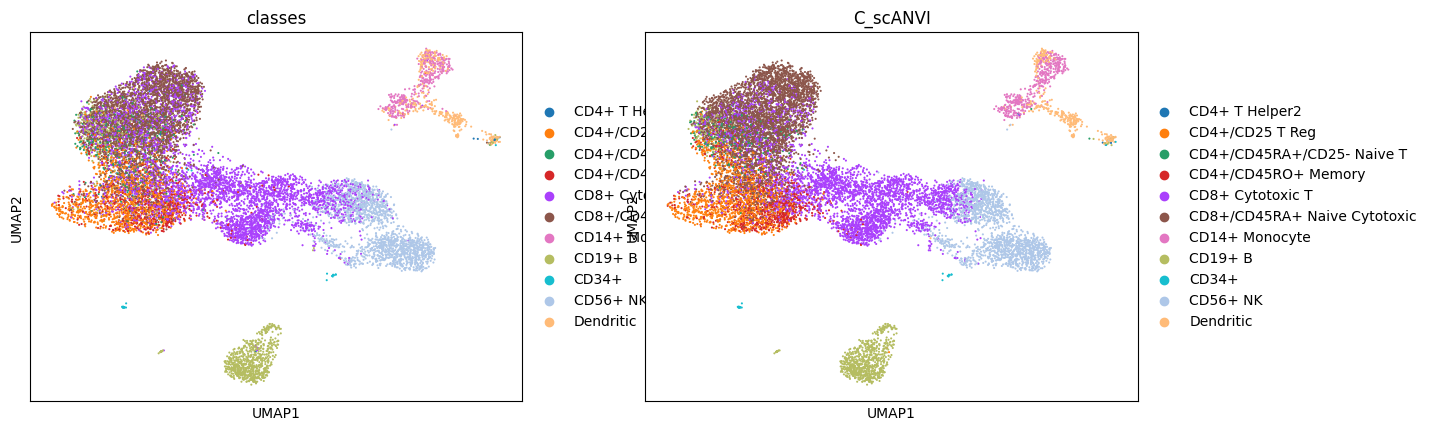

,auprc,auroc
CD4+ T Helper2,0.020303,0.747827
CD4+/CD25 T Reg,0.607687,0.927177
CD4+/CD45RA+/CD25- Naive T,0.308174,0.892354
CD4+/CD45RO+ Memory,0.381051,0.915401
CD8+ Cytotoxic T,0.829965,0.893894
CD8+/CD45RA+ Naive Cytotoxic,0.749899,0.921707
CD14+ Monocyte,0.856323,0.995814
CD19+ B,0.871929,0.969682
CD34+,0.897188,0.999470
CD56+ NK,0.968280,0.994920


In [14]:
adata2eval.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata2eval)
adata2eval.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata2eval)

sc.pp.neighbors(adata2eval, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata2eval)
sc.pl.umap(adata2eval, color=[cell_type_col, SCANVI_PREDICTIONS_KEY])

proba_df = scanvi_model.predict(adata2eval, soft=True)
proba_df_renamed = proba_df.copy()
proba_df_renamed.columns = [x+".proba" for x in proba_df_renamed.columns]
adata2eval.obs = pd.concat((adata2eval.obs, proba_df_renamed), axis=1)

labels_ordered = proba_df.columns
all_targets = np.asarray([np.where(labels_ordered==x)[0][0] for x in adata2eval.obs["classes"]])
all_pred_y_prob = proba_df.values
target_name_mapper = {i:col for i, col in enumerate(labels_ordered)}

performance = evaluate(all_targets, all_pred_y_prob, target_name_mapper)
performance